In [13]:
!pip install -q opencv-contrib-python scikit-learn tqdm joblib

In [14]:
import os, cv2, numpy as np
from tqdm import tqdm
from sklearn.cluster import MiniBatchKMeans
import joblib

base = "/content/pest12"
data = f"{base}/data"
cropsDir = os.path.join(base, "crops")
os.makedirs(cropsDir, exist_ok=True)

ops = ["train", "valid", "test"]
for option in ops:
  os.makedirs(os.path.join(cropsDir, option), exist_ok=True)


In [15]:
from google.colab import files

# secret upload to enable api use to download dataset on colab
uploaded = files.upload()


Saving kaggle.json to kaggle.json


In [16]:
import shutil
import pathlib
import os

pathlib.Path('/root/.kaggle').mkdir(parents=True, exist_ok=True)

shutil.move('kaggle.json', '/root/.kaggle/kaggle.json')

os.chmod('/root/.kaggle/kaggle.json', 0o600)


In [17]:
# Download dataset from Kaggle into /content/pest12/data
!kaggle datasets download -d rupankarmajumdar/crop-pests-dataset -p $data -q


Dataset URL: https://www.kaggle.com/datasets/rupankarmajumdar/crop-pests-dataset
License(s): MIT


In [18]:
import zipfile, glob

zip_files = glob.glob(os.path.join(data, "*.zip"))
print("Found zip files:", zip_files)

if len(zip_files) == 0:
    raise RuntimeError("No zip files found in data directory. Check Kaggle download.")

zip_path = zip_files[0]
with zipfile.ZipFile(zip_path, 'r') as z:
    z.extractall(data)

print("Unzipped to:", data)
print("Contents:", os.listdir(data))


Found zip files: ['/content/pest12/data/crop-pests-dataset.zip']
Unzipped to: /content/pest12/data
Contents: ['train', 'data.yaml', 'test', 'crop-pests-dataset.zip', 'valid']


In [19]:
def YOLO_pix(xc, yc, w, h, imgw, imgh):
    # Convert YOLO-normalised coords to pixel coords
    xc = xc * imgw
    yc = yc * imgh
    w  = w  * imgw
    h  = h  * imgh

    xmin = int(max(0, xc - (w/2)))
    ymin = int(max(0, yc - (h/2)))
    xmax = int(min(imgw - 1, xc + (w/2)))
    ymax = int(min(imgh - 1, yc + (h/2)))

    return xmin, ymin, xmax, ymax


In [20]:
def setSplit(split, max=None):
    # given split ('train', 'validate', 'test')
    # loop over DATA/{split}/labels
    # crop each bbox and save under cropsDir/split/classId/stem_i.jpg

    imgDir   = os.path.join(data, split, "images")
    labelDir = os.path.join(data, split, "labels")
    outBase  = os.path.join(cropsDir, split)

    labelFiles = sorted([f for f in os.listdir(labelDir) if f.endswith(".txt")])

    # throttle if max is provided
    if max is not None:
        labelFiles = labelFiles[:max]

    count = 0

    for labFile in tqdm(labelFiles, desc=f"Cropping {split}"):
        stem = os.path.splitext(labFile)[0]

        # try .jpg then .png
        imgPath = os.path.join(imgDir, stem + ".jpg")
        if not os.path.exists(imgPath):
            imgPath = os.path.join(imgDir, stem + ".png")
            if not os.path.exists(imgPath):
                continue  # skip unmatched images

        img = cv2.imread(imgPath)
        if img is None:
            continue

        imgh, imgw = img.shape[:2]

        with open(os.path.join(labelDir, labFile)) as f:
            for i, line in enumerate(f):
                parts = line.strip().split()
                if len(parts) != 5:
                    continue

                clsId = int(parts[0])
                xc, yc, w, h = map(float, parts[1:])

                xmin, ymin, xmax, ymax = YOLO_pix(xc, yc, w, h, imgw, imgh)
                crop = img[ymin:ymax, xmin:xmax]

                # skip degenerate boxes
                if crop.size == 0:
                    continue

                # ensure class folder exists
                classDir = os.path.join(outBase, str(clsId))
                os.makedirs(classDir, exist_ok=True)

                outName = f"{stem}_{i}.jpg"
                outPath = os.path.join(classDir, outName)

                cv2.imwrite(outPath, crop)
                count += 1

    print(f"{split}: saved {count} crops.")


In [21]:
setSplit("train")      # or setSplit("train", max=300) for quick test
setSplit("valid")
setSplit("test")


Cropping train: 100%|██████████| 11502/11502 [00:45<00:00, 250.26it/s]


train: saved 15282 crops.


Cropping valid: 100%|██████████| 1095/1095 [00:03<00:00, 273.83it/s]


valid: saved 1341 crops.


Cropping test: 100%|██████████| 546/546 [00:01<00:00, 275.59it/s]

test: saved 689 crops.


In [ ]:
sift = cv2.SIFT_create()

def getDesc(imgPath, max=None):
    img = cv2.imread(imgPath, cv2.IMREAD_GRAYSCALE)
    if img is None:
        return None

    keyPoints, desc = sift.detectAndCompute(img, None)
    if desc is None or len(keyPoints) == 0:
        return None

    # throttle descriptors
    if max is not None and desc.shape[0] > max:
        idx = np.random.choice(desc.shape[0], max, replace=False)
        desc = desc[idx]

    return desc


def collectDesc(split, maxImgs, maxDescperImg):
    base = os.path.join(cropsDir, split)
    allDescs = []

    classIds = sorted([d for d in os.listdir(base)
                       if os.path.isdir(os.path.join(base, d))])

    for cls in classIds:
        classDir = os.path.join(base, cls)
        imgFiles = sorted(os.listdir(classDir))

        # throttle
        imgFiles = imgFiles[:maxImgs]

        for img in tqdm(imgFiles, desc=f"Collecting descriptors for {split}, class {cls}"):
            imgPath = os.path.join(classDir, img)
            desc = getDesc(imgPath, max=maxDescperImg)
            if desc is not None:
                allDescs.append(desc)

    if len(allDescs) == 0:
        raise RuntimeError("No descriptors collecte")

    allDescs = np.vstack(allDescs)
    print("Total collected:", allDescs.shape)
    return allDescs


# test runnner
trainDesc = collectDesc(split="train", maxImgs=None, maxDescperImg=None) # change if neeeded to run quicker


Total collected: (28988, 128)


In [23]:
# building the BoVW from trainDesc ^^

K = 500 # visual vocab

print("Fitting MiniBatchKMeans with K =", K, "on", trainDesc.shape[0], "descriptors")

kmeans = MiniBatchKMeans(
    n_clusters=K,
    batch_size=4096,
    verbose=1,
    random_state=42
)

kmeans.fit(trainDesc)
print("Inertia", kmeans.inertia_)

vocab = os.path.join(base, f"kmeans_sift_K{K}.joblib")
joblib.dump(kmeans, vocab)
print("Save")

Fitting MiniBatchKMeans with K = 500 on 28988 descriptors
Init 1/1 with method k-means++
Inertia for init 1/1: 1253308416.0
[MiniBatchKMeans] Reassigning 5 cluster centers.
Minibatch step 1/707: mean batch inertia: 102767.578125
Minibatch step 2/707: mean batch inertia: 77962.4140625, ewa inertia: 77962.4140625
[MiniBatchKMeans] Reassigning 8 cluster centers.
Minibatch step 3/707: mean batch inertia: 75005.7890625, ewa inertia: 77126.90155775682
Minibatch step 4/707: mean batch inertia: 74354.640625, ewa inertia: 76343.4884851726
[MiniBatchKMeans] Reassigning 6 cluster centers.
Minibatch step 5/707: mean batch inertia: 73573.90625, ewa inertia: 75560.83238559918
Minibatch step 6/707: mean batch inertia: 73359.03125, ewa inertia: 74938.62551737922
[MiniBatchKMeans] Reassigning 6 cluster centers.
Minibatch step 7/707: mean batch inertia: 72765.515625, ewa inertia: 74324.52650608629
Minibatch step 8/707: mean batch inertia: 72068.9296875, ewa inertia: 73687.11751861314
[MiniBatchKMeans] R

In [24]:
def descToHist(desc, kmModel, K):
    # turn SIFT desc for one image into a K-dim BoVW hist

    if desc is None or desc.shape[0] == 0:
        hist = np.zeros(K, dtype=np.float32)
    else:
        words = kmModel.predict(desc)
        hist = np.bincount(words, minlength=K).astype(np.float32)

    # L2
    n = np.linalg.norm(hist)
    if n > 0:
        hist /= n

    return hist


def buildFeat(split, kmModel, K, maxImgs=None, maxDesc=None):
    base = os.path.join(cropsDir, split)

    classIds = sorted([
        d for d in os.listdir(base)
        if os.path.isdir(os.path.join(base, d))
    ])

    X_list = []
    y_list = []

    for cls in classIds:
        classDir = os.path.join(base, cls)
        imgFiles = sorted(os.listdir(classDir))

        # throttle images if needed
        if maxImgs is not None:
            imgFiles = imgFiles[:maxImgs]

        for imgName in tqdm(imgFiles,
                            desc=f"BoVW {split}, class {cls}",
                            leave=False):
            imgPath = os.path.join(classDir, imgName)
            desc = getDesc(imgPath, max=maxDesc)
            if desc is None:
                continue

            hist = descToHist(desc, kmModel, K)
            X_list.append(hist)
            y_list.append(int(cls))

    if len(X_list) == 0:
        raise RuntimeError(f"No features built for {split}")

    X = np.vstack(X_list).astype(np.float32)
    y = np.array(y_list, dtype=np.int64)
    print(split, "features:", X.shape, "labels:", y.shape)

    return X, y


# build features for each split
XTrain, yTrain = buildFeat("train",  kmeans, K)
XValid, yValid = buildFeat("valid",  kmeans, K)
XTest,  yTest  = buildFeat("test",   kmeans, K)

# save so SVM / kNN notebook can just load
featPath = os.path.join(base, f"sift_bovw_K{K}_features.npz")
np.savez(
    featPath,
    XTrain=XTrain, yTrain=yTrain,
    XValid=XValid, yValid=yValid,
    XTest=XTest,   yTest=yTest,
)
print("saved features to:", featPath)


train features: (15265, 500) labels: (15265,)


valid features: (1338, 500) labels: (1338,)


test features: (689, 500) labels: (689,)
saved features to: /content/pest12/sift_bovw_K500_features.npz


In [25]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    roc_auc_score
)

import matplotlib.pyplot as plt
import seaborn as sns


In [26]:
Cs = [0.1, 1.0, 10.0]

bestC = None
bestAcc = -1
bestSVM = None

for C in Cs:
# Build a simple pipeline: scale features (important for SVM) + Linear SVM classifier

    clf = make_pipeline(
        StandardScaler(with_mean=False),
        LinearSVC(C=C, random_state=42)
    )

# Train on the BoVW features extracted from training crops

    clf.fit(XTrain, yTrain)


# Evaluate on validation split to avoid overfitting to full dataset

    yPredVal = clf.predict(XValid)
    acc = accuracy_score(yValid, yPredVal)



    if acc > bestAcc:
        bestAcc = acc
        bestC = C
        bestSVM = clf

print("Best C =", bestC, "with val acc =", bestAcc)


Best C = 0.1 with val acc = 0.4133034379671151


SVM val accuracy: 0.4133034379671151

SVM val classification report:

              precision    recall  f1-score   support

           0       0.41      0.59      0.48       178
           1       0.34      0.42      0.37       110
           2       0.14      0.04      0.06       100
           3       0.43      0.42      0.42       136
           4       0.19      0.21      0.20        72
           5       0.26      0.13      0.18       104
           6       0.41      0.36      0.39       102
           7       0.46      0.58      0.52       101
           8       0.26      0.15      0.19        91
           9       0.51      0.56      0.54       107
          10       0.49      0.52      0.50       132
          11       0.59      0.70      0.64       105

    accuracy                           0.41      1338
   macro avg       0.37      0.39      0.37      1338
weighted avg       0.39      0.41      0.39      1338



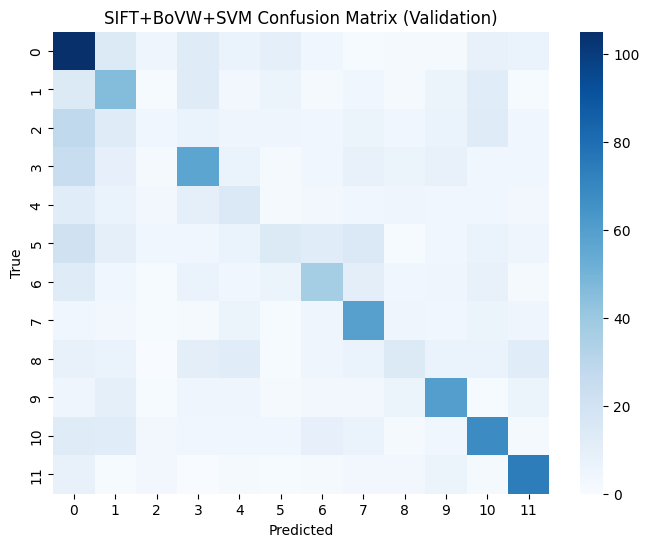

In [27]:
# Use the best SVM (selected from hyperparameter tuning) to make predictions on the validation set
yValPred = bestSVM.predict(XValid)
print("SVM val accuracy:", accuracy_score(yValid, yValPred))
print("\nSVM val classification report:\n")
print(classification_report(yValid, yValPred))
# Build a confusion matrix to visualise classes
cm_val = confusion_matrix(yValid, yValPred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_val, cmap="Blues", annot=False)
plt.title("SIFT+BoVW+SVM Confusion Matrix (Validation)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


In [28]:
from sklearn.metrics import roc_auc_score
import numpy as np

scaler_svm = bestSVM.named_steps["standardscaler"]
svm_core   = bestSVM.named_steps["linearsvc"]

XValScaled = scaler_svm.transform(XValid)
scoresVal  = svm_core.decision_function(XValScaled)

classes = np.unique(yValid)
auc_list = []

for idx, c in enumerate(classes):
    # binary labels: 1 for this class, 0 for others
    y_bin = (yValid == c).astype(int)
    # corresponding score column
    scores_c = scoresVal[:, idx]
    try:
        auc_c = roc_auc_score(y_bin, scores_c)
        auc_list.append(auc_c)
    except ValueError:
        # handle degenerate case
        pass

aucVal_macro = np.mean(auc_list)
print("SVM val macro AUC (OvR manual):", aucVal_macro)


SVM val macro AUC (OvR manual): 0.7986358019494132


In [29]:
# Apply the same scaling used during training to the test features
XTestScaled = scaler_svm.transform(XTest)

scoresTest = svm_core.decision_function(XTestScaled)
classes = np.unique(yTest)

auc_list_test = []
for idx, c in enumerate(classes):
    y_bin = (yTest == c).astype(int)
    scores_c = scoresTest[:, idx]

    # Compute AUC; skip classes where it cannot be computed
    try:
        auc_c = roc_auc_score(y_bin, scores_c)
        auc_list_test.append(auc_c)
    except ValueError:
        # Occurs if y_bin has only one class
        pass

# Macro-average the AUC values across all classes
aucTest_macro = np.mean(auc_list_test)
print("SVM test macro AUC (OvR manual):", aucTest_macro)


SVM test macro AUC (OvR manual): 0.7899271559823213


SVM Test Accuracy: 0.386066763425254

SVM Test Classification Report:

              precision    recall  f1-score   support

           0       0.36      0.52      0.42        87
           1       0.27      0.41      0.33        44
           2       0.38      0.07      0.12        44
           3       0.53      0.49      0.51        93
           4       0.26      0.40      0.31        40
           5       0.35      0.18      0.24        73
           6       0.33      0.31      0.32        55
           7       0.48      0.57      0.52        47
           8       0.26      0.14      0.18        51
           9       0.34      0.34      0.34        50
          10       0.38      0.45      0.41        47
          11       0.56      0.62      0.59        58

    accuracy                           0.39       689
   macro avg       0.37      0.37      0.36       689
weighted avg       0.39      0.39      0.37       689



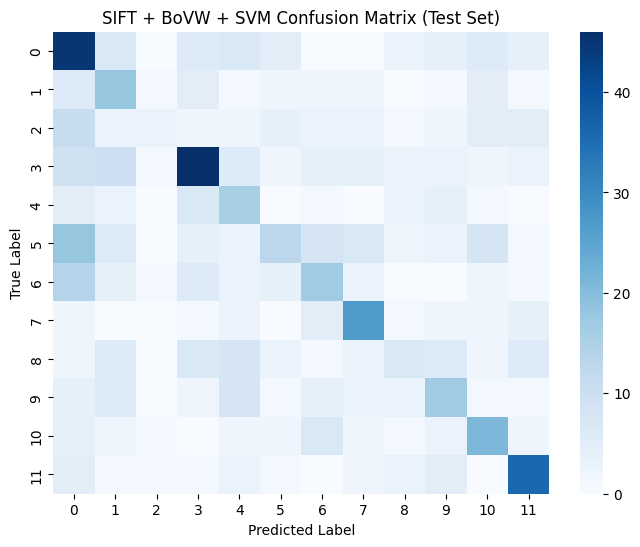

SVM Test Macro AUC (One-vs-Rest): 0.7899271559823213


In [30]:
# Generate predicted labels for the held-out test data
yTestPred = bestSVM.predict(XTest)
print("SVM Test Accuracy:", accuracy_score(yTest, yTestPred))
print("\nSVM Test Classification Report:\n")
print(classification_report(yTest, yTestPred))

# Compute and visualise the confusion matrix
cm_test = confusion_matrix(yTest, yTestPred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_test, cmap="Blues", annot=False)
plt.title("SIFT + BoVW + SVM Confusion Matrix (Test Set)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


# Scale the test features using the fitted training scaler
XTestScaled = scaler_svm.transform(XTest)

# Decision function outputs raw class scores
scoresTest = svm_core.decision_function(XTestScaled)

classes = np.unique(yTest)
auc_list_test = []

# Compute per-class AUC values
for idx, c in enumerate(classes):
    y_bin = (yTest == c).astype(int)

    scores_c = scoresTest[:, idx]

    try:
        auc_c = roc_auc_score(y_bin, scores_c)
        auc_list_test.append(auc_c)
    except ValueError:
        continue

# Final macro-average AUC across all valid classes
aucTest_macro = np.mean(auc_list_test)
print("SVM Test Macro AUC (One-vs-Rest):", aucTest_macro)

In [31]:
# basially same as the same best C
ks = [3, 5, 7]

bestK = None
bestAccKNN = -1
bestKNN = None

for k in ks:
    clf = make_pipeline(
        StandardScaler(with_mean=False),
        KNeighborsClassifier(n_neighbors=k)
    )
    clf.fit(XTrain, yTrain)
    yPredVal = clf.predict(XValid)
    acc = accuracy_score(yValid, yPredVal)

    if acc > bestAccKNN:
        bestAccKNN = acc
        bestK = k
        bestKNN = clf

print("Best k =", bestK, "with val acc =", bestAccKNN)


Best k = 7 with val acc = 0.18535127055306427


kNN val accuracy: 0.18535127055306427

kNN val classification report:

              precision    recall  f1-score   support

           0       0.33      0.31      0.32       178
           1       0.30      0.03      0.05       110
           2       0.17      0.10      0.12       100
           3       0.21      0.03      0.05       136
           4       0.13      0.24      0.17        72
           5       0.14      0.19      0.16       104
           6       0.21      0.25      0.23       102
           7       0.11      0.60      0.19       101
           8       0.08      0.02      0.03        91
           9       0.32      0.09      0.14       107
          10       0.12      0.03      0.05       132
          11       0.64      0.33      0.44       105

    accuracy                           0.19      1338
   macro avg       0.23      0.19      0.16      1338
weighted avg       0.24      0.19      0.17      1338



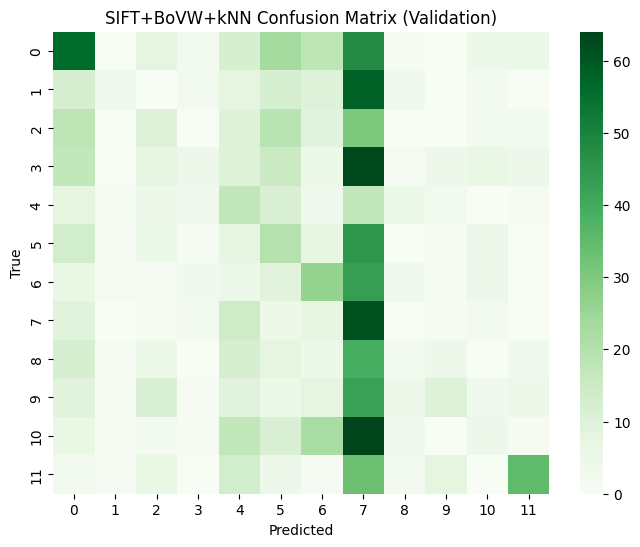

In [32]:
#same as before too
yValPredKNN = bestKNN.predict(XValid)
print("kNN val accuracy:", accuracy_score(yValid, yValPredKNN))
print("\nkNN val classification report:\n")
print(classification_report(yValid, yValPredKNN))

cm_val_knn = confusion_matrix(yValid, yValPredKNN)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_val_knn, cmap="Greens", annot=False)
plt.title("SIFT+BoVW+kNN Confusion Matrix (Validation)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


In [33]:
scaler_knn = bestKNN.named_steps["standardscaler"]
knn_core   = bestKNN.named_steps["kneighborsclassifier"]

XValScaled_knn = scaler_knn.transform(XValid)
probsVal = knn_core.predict_proba(XValScaled_knn)   # rows sum to 1

aucValKNN = roc_auc_score(yValid, probsVal, multi_class="ovr", average="macro")
print("kNN val macro AUC (OvR):", aucValKNN)


kNN val macro AUC (OvR): 0.6227510312956867


kNN test accuracy: 0.21915820029027577

kNN test classification report:

              precision    recall  f1-score   support

           0       0.31      0.29      0.30        87
           1       0.29      0.05      0.08        44
           2       0.21      0.07      0.10        44
           3       0.73      0.20      0.32        93
           4       0.15      0.28      0.19        40
           5       0.22      0.19      0.20        73
           6       0.23      0.27      0.25        55
           7       0.11      0.66      0.19        47
           8       0.22      0.04      0.07        51
           9       0.64      0.14      0.23        50
          10       0.06      0.02      0.03        47
          11       0.62      0.36      0.46        58

    accuracy                           0.22       689
   macro avg       0.31      0.21      0.20       689
weighted avg       0.35      0.22      0.22       689



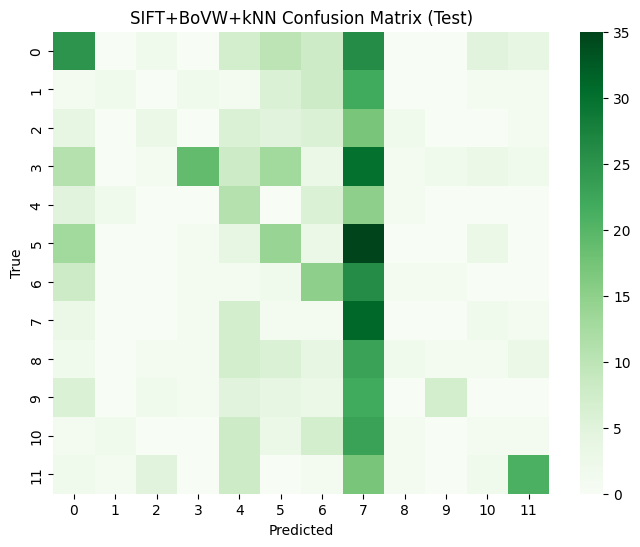

kNN test macro AUC (OvR): 0.6410222202120088


In [34]:
yTestPredKNN = bestKNN.predict(XTest)
print("kNN test accuracy:", accuracy_score(yTest, yTestPredKNN))
print("\nkNN test classification report:\n")
print(classification_report(yTest, yTestPredKNN))

cm_test_knn = confusion_matrix(yTest, yTestPredKNN)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_test_knn, cmap="Greens", annot=False)
plt.title("SIFT+BoVW+kNN Confusion Matrix (Test)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

XTestScaled_knn = scaler_knn.transform(XTest)
probsTest = knn_core.predict_proba(XTestScaled_knn)
aucTestKNN = roc_auc_score(yTest, probsTest, multi_class="ovr", average="macro")
print("kNN test macro AUC (OvR):", aucTestKNN)


In [38]:
import numpy as np
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    classification_report,
    roc_auc_score
)

# quick helper for macro AUC
def svm_macro_auc(clf, X, y):
    scaler = clf.named_steps["standardscaler"]
    svm = clf.named_steps["linearsvc"]

    X_scaled = scaler.transform(X)
    scores = svm.decision_function(X_scaled)  # shape:

    aucs = []
    for i, c in enumerate(np.unique(y)):
        y_bin = (y == c).astype(int)
        try:
            aucs.append(roc_auc_score(y_bin, scores[:, i]))
        except ValueError:
            # if only one class present we can skip
            continue

    if len(aucs) == 0:
        return np.nan
    return np.mean(aucs)


# SVM on test set
y_pred_svm = bestSVM.predict(XTest)
acc_svm = accuracy_score(yTest, y_pred_svm)
prec_svm, rec_svm, f1_svm, _ = precision_recall_fscore_support(
    yTest, y_pred_svm, average="macro"
)
auc_svm = svm_macro_auc(bestSVM, XTest, yTest)

print("SIFT + BoVW + SVM (test)")
print("accuracy:", acc_svm)
print("precision (macro):", prec_svm)
print("recall (macro):", rec_svm)
print("f1 (macro):", f1_svm)
print("macro AUC (OvR):", auc_svm)
print("\nclassification report:\n")
print(classification_report(yTest, y_pred_svm))


# kNN on test set
y_pred_knn = bestKNN.predict(XTest)
acc_knn = accuracy_score(yTest, y_pred_knn)
prec_knn, rec_knn, f1_knn, _ = precision_recall_fscore_support(
    yTest, y_pred_knn, average="macro"
)

scaler_knn = bestKNN.named_steps["standardscaler"]
knn_core = bestKNN.named_steps["kneighborsclassifier"]
XTest_scaled_knn = scaler_knn.transform(XTest)
probs_knn = knn_core.predict_proba(XTest_scaled_knn)
auc_knn = roc_auc_score(yTest, probs_knn, multi_class="ovr", average="macro")

print("\nSIFT + BoVW + kNN (test)")
print("accuracy:", acc_knn)
print("precision (macro):", prec_knn)
print("recall (macro):", rec_knn)
print("f1 (macro):", f1_knn)
print("macro AUC (OvR):", auc_knn)
print("\nclassification report:\n")
print(classification_report(yTest, y_pred_knn))


SIFT + BoVW + SVM (test)
accuracy: 0.386066763425254
precision (macro): 0.3748768456279116
recall (macro): 0.3746276680205551
f1 (macro): 0.35765254633472593
macro AUC (OvR): 0.7899271559823213

classification report:

              precision    recall  f1-score   support

           0       0.36      0.52      0.42        87
           1       0.27      0.41      0.33        44
           2       0.38      0.07      0.12        44
           3       0.53      0.49      0.51        93
           4       0.26      0.40      0.31        40
           5       0.35      0.18      0.24        73
           6       0.33      0.31      0.32        55
           7       0.48      0.57      0.52        47
           8       0.26      0.14      0.18        51
           9       0.34      0.34      0.34        50
          10       0.38      0.45      0.41        47
          11       0.56      0.62      0.59        58

    accuracy                           0.39       689
   macro avg       0.37

end